In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import financial.data as fd
import financial.model as fm
import financial.portfolio as fp
import financial.strategies.simulation as fss
from financial.io.file.cache import FileCache
from financial.io.cache import AppendStrategy
from financial.io.file.model import FileModelProvider
from financial.io.cache import NoUpdateStrategy

import os
from dotenv import load_dotenv
from financial.momentum.utilities import find_dotenv
from financial.momentum.experiment.modelExperiment import ModelExperimentFactory

2025-07-25 09:15:22.466767: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-25 09:15:22.591825: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753427722.628335   45649 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753427722.641046   45649 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1753427722.770525   45649 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [4]:
load_dotenv(dotenv_path=find_dotenv())

cache = os.environ["CACHE"] + "/"
model = os.environ["MODEL"]

ds = fd.CachedDataStore(path=os.environ["DATA"], cache=FileCache(cache_path=os.environ["CACHE"]+"/", update_strategy=NoUpdateStrategy()))
mp = FileModelProvider(model_path=model)
mc = fm.ModelCache(ds, mp, cache=FileCache(update_strategy=AppendStrategy(), cache_path=model))
uc = fm.UnifiedCache(ds, mc)

In [5]:
from financial.momentum.indicators.kerasIndicator import KerasIndicator
simulation_indicator = KerasIndicator("rnn")

In [6]:
simulation_universe = ['BLK', '^IBEX', 'BAM', '^IXIC', 'GOOG', 'TSLA']
import financial.strategies.allocation as fsa
import financial.strategies.filter as fsf
import financial.strategies.rank as fsr

simulation_filter = fsf.CompositeAssetFilter( [fsf.TopKAssetFilter(k=3), fsf.MinimumValueAssetFilter(threshold=0.0)] )
simulation_allocation = fsa.EqualWeightAllocation()
simulation_strategy = fsr.AssetRankingStrategy("Simulation", simulation_universe, simulation_indicator, simulation_filter, simulation_allocation)
print(simulation_strategy)

Simulation
- 6 asset universe: ['BLK', '^IBEX', 'BAM', '^IXIC', 'GOOG', 'TSLA']
- Indicator: {'type': 'financial.momentum.indicators.kerasIndicator.KerasIndicator', 'model': 'rnn'}


In [7]:
%%time
import financial.strategies.rebalance as fsrebalance

strategy_simulation = "simulation"
strategy = simulation_strategy
benchmark = fp.BenchmarkPortfolio("^GSPC")
market = ds.get_data("^GSPC")
rebalancing = fsrebalance.MonthlyRebalancingSchedule(-1,market) # +1 first day, -1 last day, +2 second day with 1st day momentum

print("STRATEGY")
print(strategy)
print("BENCHMARK")
print(benchmark)
print("REBALANCING")
print(rebalancing)

simulation = fss.StockStrategySimulation(uc, strategy, rebalancing, market)
simulation.verbose = True  # verbose 41.7s vs. 27s without trading details
simulation_start_year = 2010
simulation_end_year = 2024
simulation.simulate(start_year=simulation_start_year, end_year=simulation_end_year)

STRATEGY
Simulation
- 6 asset universe: ['BLK', '^IBEX', 'BAM', '^IXIC', 'GOOG', 'TSLA']
- Indicator: {'type': 'financial.momentum.indicators.kerasIndicator.KerasIndicator', 'model': 'rnn'}
BENCHMARK
^GSPC(^GSPC)
REBALANCING
Rebalancing schedule: Monthly rebalancing on -1
INITIAL PORTFOLIO
Stocks: ['$$$']
Portfolio value: 1000000.00
Portfolio assets: {'$$$': 1000000.0}
Portfolio stocks: {'$$$': 1000000}
Portfolio weights: {'$$$': 1.0}
+ Rebalance @ 2010-01-28
- Portfolio value: $1000000.00
{'^IBEX': 0.3333333333333333, '^IXIC': 0.3333333333333333, 'BLK': 0.3333333333333333}
+ Trade @ 2010-01-29
<class 'numpy.float64'>
5598.157592773379
- Changes: {'^IXIC': 155, '$$$': -994401.8424072266, 'BLK': 1558, '^IBEX': 30}
- Rotation: 99.44%
Before $1000000.00:
- Stocks: {'$$$': 1000000}
- Assets: {'$$$': 1000000.0}
Selling $$$: -994401.84x$1.00 = $-994401.84
Buying ^IXIC: 155.00x$2147.35 = $332839.27
Buying BLK: 1558.00x$213.82 = $333131.57
Buying ^IBEX: 30.00x$10947.70 = $328431.01
After $1000

In [8]:
year_returns = simulation.year_returns()

print("\nSTRATEGY RETURNS")
for year in year_returns:
    print(f"{year}: {100*year_returns[year]:6.2f}%")


cumulative = simulation.cumulative_returns(year_returns)

print("\nCUMULATIVE RETURNS")
for year in cumulative:
    print(f"{year}: {100*cumulative[year]:6.2f}%")


STRATEGY RETURNS
2010:   1.65%
2011:  -5.70%
2012:  10.42%
2013:  37.66%
2014:  10.77%
2015:  -1.11%
2016:   6.66%
2017:  23.19%
2018: -12.76%
2019:  24.92%
2020:  21.22%
2021:  18.84%
2022: -18.53%
2023:  26.28%
2024:  22.99%

CUMULATIVE RETURNS
2010:   1.65%
2011:  -4.15%
2012:   5.85%
2013:  45.71%
2014:  61.41%
2015:  59.62%
2016:  70.26%
2017: 109.74%
2018:  82.97%
2019: 128.57%
2020: 177.06%
2021: 229.27%
2022: 168.25%
2023: 238.75%
2024: 316.63%


In [9]:
import financial.portfolios.statistics as fps
assets = {'^GSPC': 1.0}
target = fp.WeightedPortfolio.from_assets("Target", assets)
benchmark_returns = target.returns(ds,'2010-12-31','2024-12-31')
benchmark_monthly_returns = fss.SimulationUtilities.monthly_returns(ds,target,2010,2024)
benchmark_cumulative_returns = fps.CumulativeReturn().get_series(benchmark_monthly_returns)

In [10]:
benchmark_monthly_returns = fss.SimulationUtilities.monthly_returns(ds,target,simulation_start_year,simulation_end_year)
benchmark_cumulative_returns = fps.CumulativeReturn().get_series(benchmark_monthly_returns)
fss.SimulationReport.simulation_report(benchmark_monthly_returns, fss.accumulate_return)

          TOTAL     YEAR     Jan     Feb     Mar     Apr     May     Jun     Jul     Aug     Sep     Oct     Nov     Dec
  2010:   12.78%   12.78%  -3.70%   2.85%   5.88%   1.48%  -8.20%  -5.39%   6.88%  -4.74%   8.76%   3.69%  -0.23%   6.53%
  2011:   12.78%   -0.00%   2.26%   3.20%  -0.10%   2.85%  -1.35%  -1.83%  -2.15%  -5.68%  -7.18%  10.77%  -0.51%   0.85%
  2012:   27.90%   13.41%   4.36%   4.06%   3.13%  -0.75%  -6.27%   3.96%   1.26%   1.98%   2.42%  -1.98%   0.28%   0.71%
  2013:   65.76%   29.60%   5.04%   1.11%   3.60%   1.81%   2.08%  -1.50%   4.95%  -3.13%   2.97%   4.46%   2.80%   2.36%
  2014:   84.64%   11.39%  -3.56%   4.31%   0.69%   0.62%   2.10%   1.91%  -1.51%   3.77%  -1.55%   2.32%   2.45%  -0.42%
  2015:   83.30%   -0.73%  -3.10%   5.49%  -1.74%   0.85%   1.05%  -2.10%   1.97%  -6.26%  -2.64%   8.30%   0.05%  -1.75%
  2016:  100.77%    9.54%  -5.07%  -0.41%   6.60%   0.27%   1.53%   0.09%   3.56%  -0.12%  -0.12%  -1.94%   3.42%   1.82%
  2017:  139.76%   19.42%

In [11]:
rotation = simulation.monthly_rotation()
print(f"Average monthly rotation: {100*rotation:.2f}%")

Average monthly rotation: 1.77%


In [12]:
year_returns = simulation.year_returns()
#print(year_returns)

print("\nSTRATEGY RETURNS")
for year in year_returns:
    print(f"{year}: {100*year_returns[year]:6.2f}%")


cumulative = simulation.cumulative_returns(year_returns)

print("\nCUMULATIVE RETURNS")
for year in cumulative:
    print(f"{year}: {100*cumulative[year]:6.2f}%")


STRATEGY RETURNS
2010:   1.65%
2011:  -5.70%
2012:  10.42%
2013:  37.66%
2014:  10.77%
2015:  -1.11%
2016:   6.66%
2017:  23.19%
2018: -12.76%
2019:  24.92%
2020:  21.22%
2021:  18.84%
2022: -18.53%
2023:  26.28%
2024:  22.99%

CUMULATIVE RETURNS
2010:   1.65%
2011:  -4.15%
2012:   5.85%
2013:  45.71%
2014:  61.41%
2015:  59.62%
2016:  70.26%
2017: 109.74%
2018:  82.97%
2019: 128.57%
2020: 177.06%
2021: 229.27%
2022: 168.25%
2023: 238.75%
2024: 316.63%


In [19]:
%%time

year = 2016
monthly_returns = simulation.monthly_returns(year)
#print(monthly_returns)
cumulative_returns = simulation.cumulative_returns(monthly_returns)
year_return = cumulative_returns[12]

print("Monthly returns")
returns_str = [f"{100*month_return:>6.2f}%" for month_return in monthly_returns.values()]
print(f"  {year}:           {100*year_return:>6.2f}% " + " ".join(returns_str))

print("Monthly cumulative returns")
returns_str = [f"{100*month_return:>6.2f}%" for month_return in cumulative_returns.values()]
print(f"  {year}:           {100*year_return:>6.2f}% " + " ".join(returns_str))

print()
print("SERIES")
print("Monthly returns")
monthly_returns = simulation.returns()
print(monthly_returns)
cumulative_returns = fps.CumulativeReturn().get_series(monthly_returns)
print("Cumulative returns")
print(cumulative_returns)

Monthly returns
  2016:             6.66%  -7.43%  -1.90%   6.33%   1.96%   1.86%  -5.40%   5.96%   1.57%  -0.05%  -1.29%   1.99%   3.82%
Monthly cumulative returns
  2016:             6.66%  -7.43%  -9.18%  -3.43%  -1.54%   0.28%  -5.13%   0.52%   2.10%   2.04%   0.73%   2.74%   6.66%

SERIES
Monthly returns
2010-01-31    0.000000
2010-02-28    0.003427
2010-03-31    0.040960
2010-04-30   -0.054421
2010-05-31   -0.093548
                ...   
2024-08-31    0.020601
2024-09-30    0.039924
2024-10-31    0.003347
2024-11-30    0.031767
2024-12-31    0.002546
Length: 180, dtype: float64
Cumulative returns
2010-01-31    0.000000
2010-02-28    0.003427
2010-03-31    0.044527
2010-04-30   -0.012317
2010-05-31   -0.104713
                ...   
2024-08-31    2.860236
2024-09-30    3.014352
2024-10-31    3.027788
2024-11-30    3.155738
2024-12-31    3.166320
Length: 180, dtype: float64
CPU times: user 4.34 s, sys: 172 μs, total: 4.34 s
Wall time: 4.34 s


<Axes: >

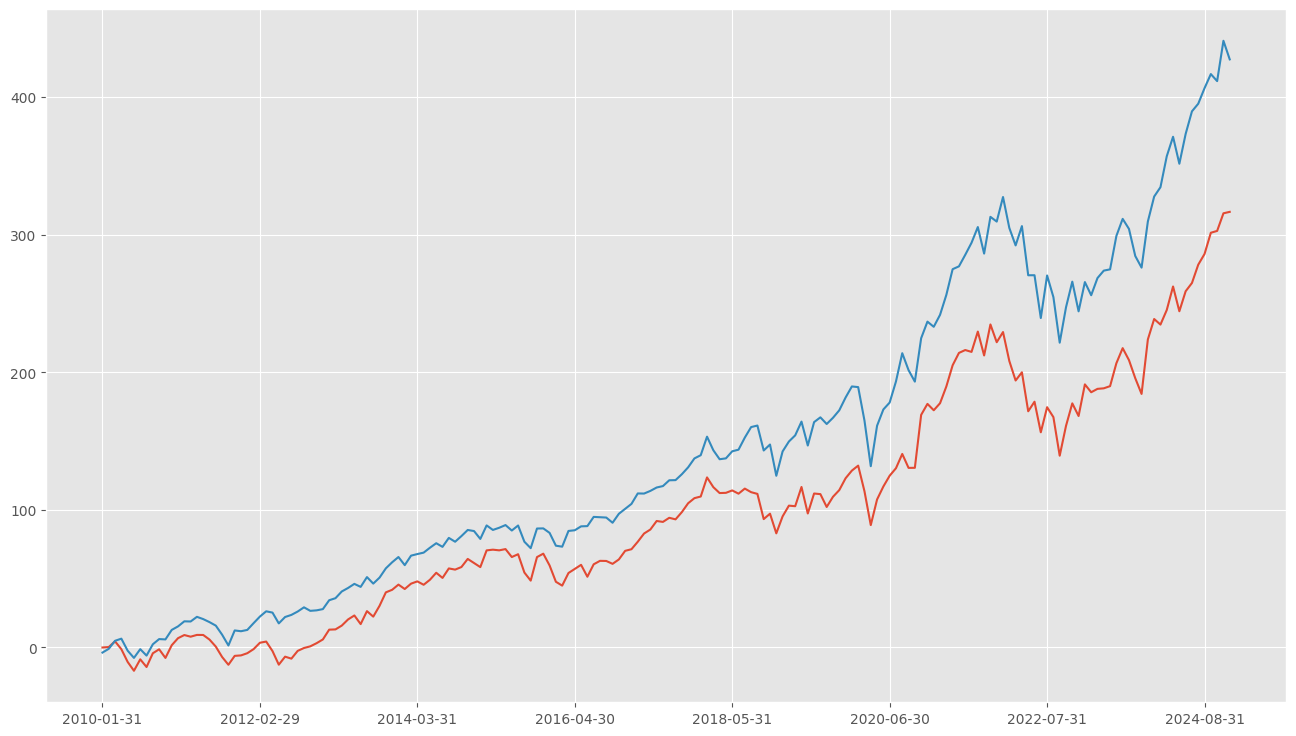

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl

mpl.rc('figure', figsize=(16, 9))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

fig = plt.figure()

benchmark = 100*benchmark_cumulative_returns
#benchmark = 100*fps.MaximumDrawdown().get_series(benchmark_monthly_returns)

data = 100*cumulative_returns
#data = 100*drawdown

#monthly_returns.plot(label=ticker)
data.plot()
benchmark.plot()